In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, trustworthiness
from sklearn.metrics import pairwise_distances

from scipy.stats import spearmanr

file_path_raw = "../../cleaned_data/joueurs_ligue1_2024_2025_clean_raw.csv"
file_path_per90 = "../../cleaned_data/joueurs_ligue1_2024_2025_clean_per90.csv"
file_path_custom = "../../cleaned_data/joueurs_ligue1_2024_2025_clean_custom_no_GK.csv"

data_raw = pd.read_csv(file_path_raw, encoding="utf-8")
data_per90 = pd.read_csv(file_path_per90, encoding="utf-8")
data_custom = pd.read_csv(file_path_custom, encoding="utf-8")
print(data_raw.columns)

Index(['equipe', 'player_id', 'player_name', 'player_country_code', 'age',
       'positions', 'matches_played', 'min', 'gls', 'ast',
       ...
       'second_yellow_cards', 'fls_com', 'fls_drawn', 'offside', 'pk_won',
       'pk_conceded', 'og', 'ball_recov', 'air_dual_won', 'air_dual_lost'],
      dtype='object', length=106)


### Pre-processing : remove non numeric columns, normalize as t-SNE (like ISOMap) is based on distances

In [50]:
def preprocessing(data):
    player_names = data['player_name']
    player_positions = data['positions']
    data_num = data.select_dtypes(include=[np.number]).dropna(axis=1, how='any')
    data_num.index = player_names
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_num)

    removed_cols = set(data.columns) - set(data_num.columns)
    print(f"Columns removed ({len(removed_cols)}): {sorted(list(removed_cols))}")
    
    return X_scaled, data_num.columns, player_positions

X_raw, cols_raw, player_positions_raw = preprocessing(data_raw)
X_per90, cols_per90, player_positions_per90 = preprocessing(data_per90)
X_custom, cols_custom, player_positions_custom = preprocessing(data_custom)

Columns removed (5): ['equipe', 'player_country_code', 'player_id', 'player_name', 'positions']
Columns removed (5): ['equipe', 'player_country_code', 'player_id', 'player_name', 'positions']
Columns removed (5): ['equipe', 'player_country_code', 'player_id', 'player_name', 'positions']


## Results Analysis

In [51]:
# Continuity
def continuity(X, X_embedded, k):
    n = X.shape[0]
    original_neighbors = np.argsort(pairwise_distances(X), axis=1)[:, 1:k+1]
    embedded_neighbors = np.argsort(pairwise_distances(X_embedded), axis=1)[:, 1:k+1]
    
    total = 0
    for i in range(n):
        orig = set(original_neighbors[i])
        emb = set(embedded_neighbors[i])
        missing = orig - emb
        total += sum([list(original_neighbors[i]).index(m) + 1 for m in missing])
    continuity_score = 1 - (2 / (n * k * (2 * n - 3 * k - 1))) * total
    return continuity_score

# MRRE (Mean Relative Rank Error)
def mrre(X, X_embedded, k):
    n = X.shape[0]
    D_high = pairwise_distances(X)
    D_low = pairwise_distances(X_embedded)

    R_high = np.argsort(np.argsort(D_high, axis=1), axis=1)
    R_low = np.argsort(np.argsort(D_low, axis=1), axis=1)

    error = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                error += abs(R_high[i][j] - R_low[i][j]) / R_high[i][j]
    return error / (n * (n - 1))

def extractMetrics_tsne(X_original, X_tsne, k=10):
    # Pairwise distances
    D_high = pairwise_distances(X_original)
    D_low = pairwise_distances(X_tsne)

    # Spearman correlation of distances
    corr, _ = spearmanr(
        D_high[np.triu_indices_from(D_high, k=1)],
        D_low[np.triu_indices_from(D_low, k=1)]
    )

    # Neighborhood metrics
    trust = trustworthiness(X_original, X_tsne, n_neighbors=k)
    cont = continuity(X_original, X_tsne, k)
    mrre_score = mrre(X_original, X_tsne, k)

    return corr, trust, cont, mrre_score


### Gridsearch for t-SNE :

In [43]:
def grid_search_tsne(data_raw, data_per90, data_custom, n_components_list, perplexity_list, learning_rate_list):
    results_raw = []
    results_per90 = []
    results_custom = []

    for n_components in n_components_list:
        for perplexity in perplexity_list:
            for learning_rate in learning_rate_list:
                
                tsne_raw = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, init='pca', random_state=42, method = "exact")
                X_tsne_raw = tsne_raw.fit_transform(data_raw)
                
                tsne_per90 = TSNE(n_components=n_components, perplexity=perplexity,learning_rate=learning_rate, init='pca', random_state=42, method = "exact")
                X_tsne_per90 = tsne_per90.fit_transform(data_per90)
                
                tsne_custom = TSNE(n_components=n_components, perplexity=perplexity,learning_rate=learning_rate, init='pca', random_state=42, method = "exact")
                X_tsne_custom = tsne_custom.fit_transform(data_custom)

                # Compute metrics
                corr_raw, trust_raw, cont_raw, mrre_raw = extractMetrics_tsne(data_raw, X_tsne_raw)
                corr_per90, trust_per90, cont_per90, mrre_per90 = extractMetrics_tsne(data_per90, X_tsne_per90)
                corr_custom, trust_custom, cont_custom, mrre_custom = extractMetrics_tsne(data_custom, X_tsne_custom)

                # Store results
                results_raw.append({
                    "n_components": n_components,
                    "perplexity": perplexity,
                    "learning_rate": learning_rate,
                    "dist_corr": corr_raw,
                    "trustworthiness": trust_raw,
                    "continuity": cont_raw,
                    "MRRE": mrre_raw
                })
                results_per90.append({
                    "n_components": n_components,
                    "perplexity": perplexity,
                    "learning_rate": learning_rate,
                    "dist_corr": corr_per90,
                    "trustworthiness": trust_per90,
                    "continuity": cont_per90,
                    "MRRE": mrre_per90
                })
                results_custom.append({
                    "n_components": n_components,
                    "perplexity": perplexity,
                    "learning_rate": learning_rate,
                    "dist_corr": corr_custom,
                    "trustworthiness": trust_custom,
                    "continuity": cont_custom,
                    "MRRE": mrre_custom
                })

    df_raw = pd.DataFrame(results_raw)
    df_per90 = pd.DataFrame(results_per90)
    df_custom = pd.DataFrame(results_custom)
    return df_raw, df_per90, df_custom

def print_metric_slice(df, metric):
    print(f"\n--- {metric.upper()} ---")
    display(df.pivot_table(
        index=["n_components", "perplexity"],
        columns="learning_rate",
        values=metric
    ))

In [58]:
components_grid = [4]
perplexity_grid = [30, 40]
learning_rate_grid = [40, 50, 60, 70, 80]

results_tsne_raw, results_tsne_per90, results_tsne_custom = grid_search_tsne(X_raw, X_per90, X_custom, components_grid, perplexity_grid, learning_rate_grid)

print("=== t-SNE on Raw data ===")
for metric in ["dist_corr", "trustworthiness", "continuity", "MRRE"]:
    print_metric_slice(results_tsne_raw, metric)

print("=== t-SNE on Per90 data ===")
for metric in ["dist_corr", "trustworthiness", "continuity", "MRRE"]:
    print_metric_slice(results_tsne_per90, metric)

print("=== t-SNE on Custom data ===")
for metric in ["dist_corr", "trustworthiness", "continuity", "MRRE"]:
    print_metric_slice(results_tsne_custom, metric)

=== t-SNE on Raw data ===

--- DIST_CORR ---


learning_rate                  40        50        60        70        80
n_components perplexity                                                  
4            30          0.701362  0.704792  0.704284  0.708924  0.595206
             40          0.660850  0.716387  0.716007  0.719558  0.696135


--- TRUSTWORTHINESS ---


learning_rate                  40        50        60        70        80
n_components perplexity                                                  
4            30          0.972118  0.973145  0.973081  0.972424  0.960335
             40          0.957922  0.974792  0.974522  0.974487  0.972039


--- CONTINUITY ---


learning_rate                  40        50        60        70        80
n_components perplexity                                                  
4            30          0.991509  0.991513  0.991526  0.991533  0.990844
             40          0.990849  0.991633  0.991515  0.991537  0.991638


--- MRRE ---


learning_rate                  40        50        60        70        80
n_components perplexity                                                  
4            30          0.425626  0.423839  0.416333  0.418695  0.601023
             40          0.504973  0.404715  0.409708  0.403774  0.442139

=== t-SNE on Per90 data ===

--- DIST_CORR ---


learning_rate                  40        50        60        70        80
n_components perplexity                                                  
4            30          0.647573  0.737144  0.743129  0.705374  0.666005
             40          0.629832  0.699474  0.746758  0.739011  0.670433


--- TRUSTWORTHINESS ---


learning_rate                  40        50        60        70        80
n_components perplexity                                                  
4            30          0.948383  0.968820  0.967747  0.965095  0.954780
             40          0.938937  0.956247  0.971148  0.967270  0.944295


--- CONTINUITY ---


learning_rate                  40        50        60        70        80
n_components perplexity                                                  
4            30          0.990566  0.991199  0.991193  0.991198  0.990860
             40          0.990465  0.990725  0.991413  0.991304  0.990387


--- MRRE ---


learning_rate                  40        50        60        70        80
n_components perplexity                                                  
4            30          0.616648  0.453617  0.451231  0.556600  0.618248
             40          0.663066  0.544891  0.440416  0.482277  0.671161

=== t-SNE on Custom data ===

--- DIST_CORR ---


learning_rate                  40        50        60        70        80
n_components perplexity                                                  
4            30          0.736739  0.747307  0.733408  0.618977  0.472913
             40          0.684705  0.758951  0.750920  0.665624  0.568317


--- TRUSTWORTHINESS ---


learning_rate                  40        50        60        70        80
n_components perplexity                                                  
4            30          0.964586  0.964072  0.965057  0.937295  0.905273
             40          0.950956  0.967604  0.966874  0.940259  0.915273


--- CONTINUITY ---


learning_rate                  40        50        60        70        80
n_components perplexity                                                  
4            30          0.990682  0.990651  0.990652  0.989972  0.989292
             40          0.990233  0.990849  0.990858  0.990064  0.989331


--- MRRE ---


learning_rate                  40        50        60        70        80
n_components perplexity                                                  
4            30          0.464924  0.462858  0.482157  0.762209  1.094221
             40          0.578132  0.437687  0.451444  0.644940  0.906928

## Best models - t-SNE computation

In [59]:
def run_tsne(X, n_components, perplexity, learning_rate = 60):
    tsne = TSNE(n_components= n_components, perplexity=perplexity, init = "pca", learning_rate=learning_rate, max_iter=3000, random_state=42, method = "exact")
    X_tsne = tsne.fit_transform(X)
    return X_tsne, tsne

X_tsne_raw, tsne_raw = run_tsne(X_raw, n_components=4, perplexity=40, learning_rate = 60)
X_tsne_per90, tsne_per90 = run_tsne(X_per90, n_components=4, perplexity=40, learning_rate = 60)
X_tsne_custom, tsne_custom = run_tsne(X_custom, n_components=4, perplexity=40, learning_rate = 60)

### Results Display

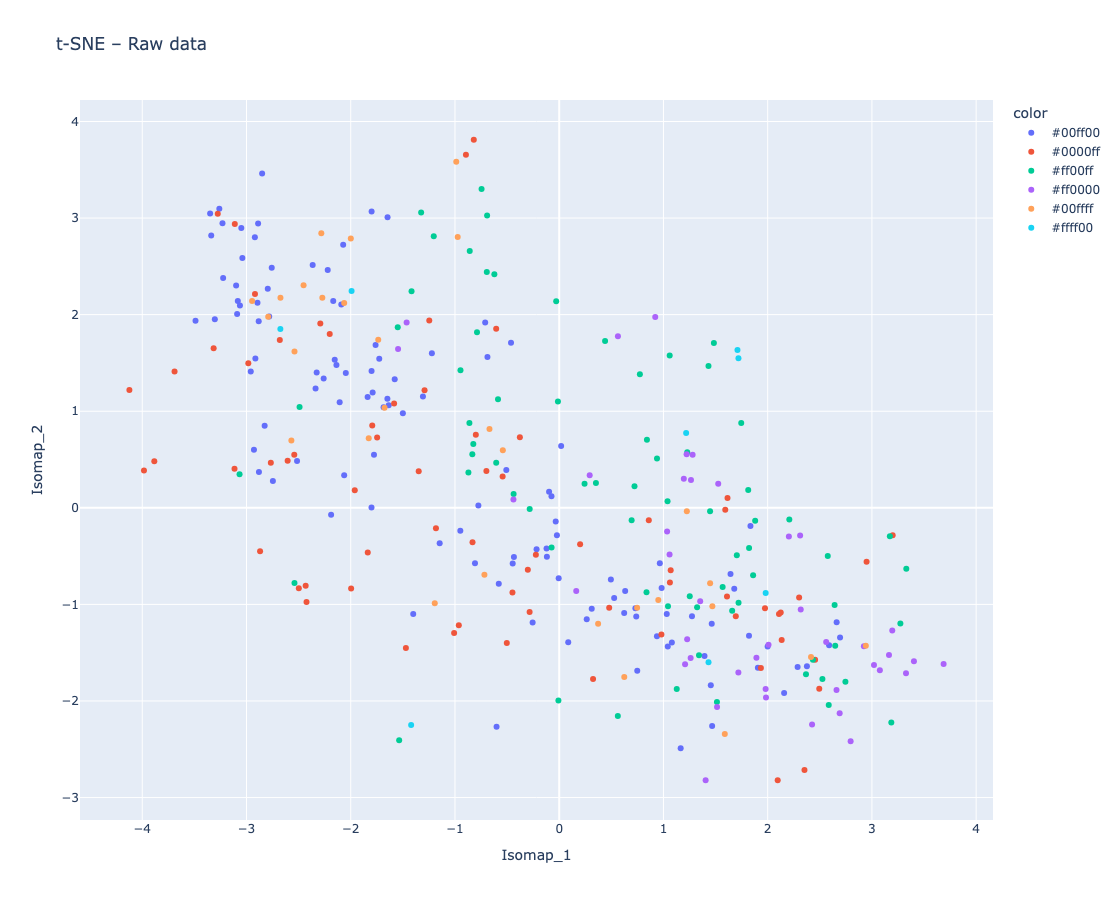

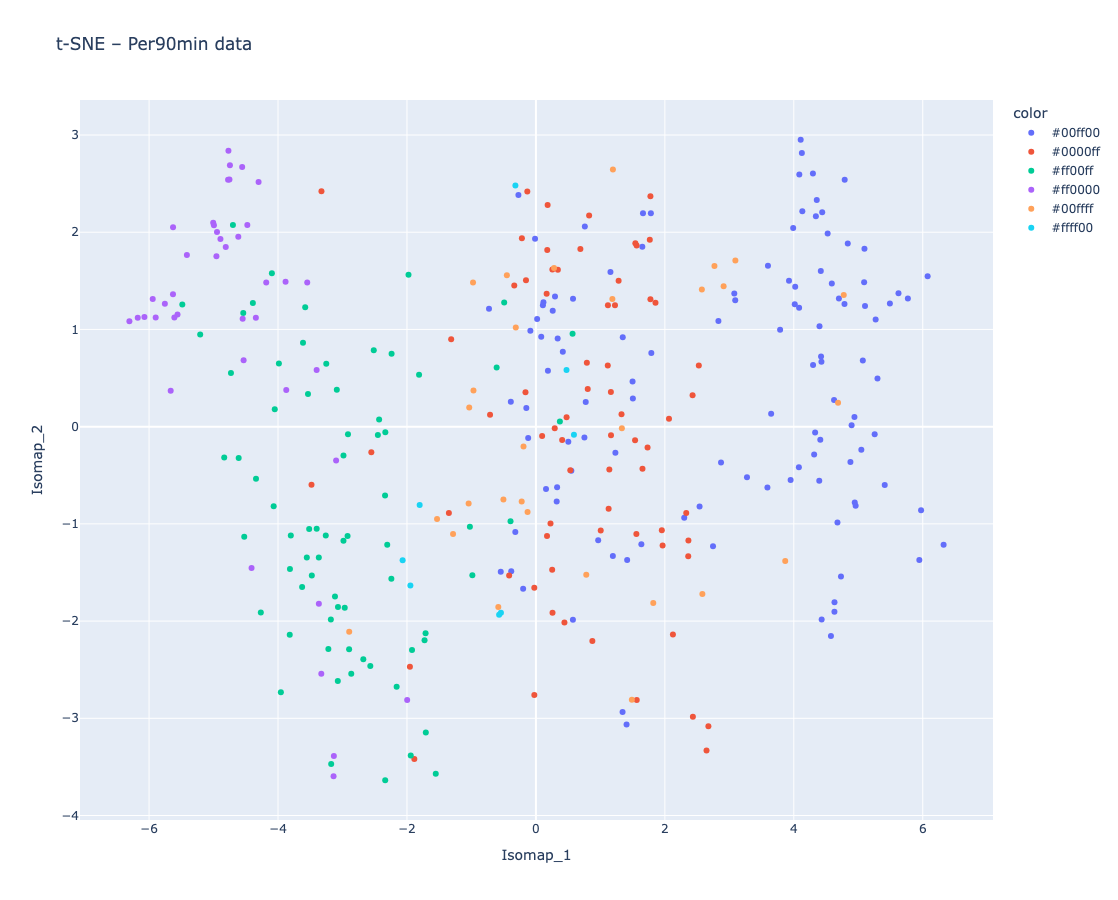

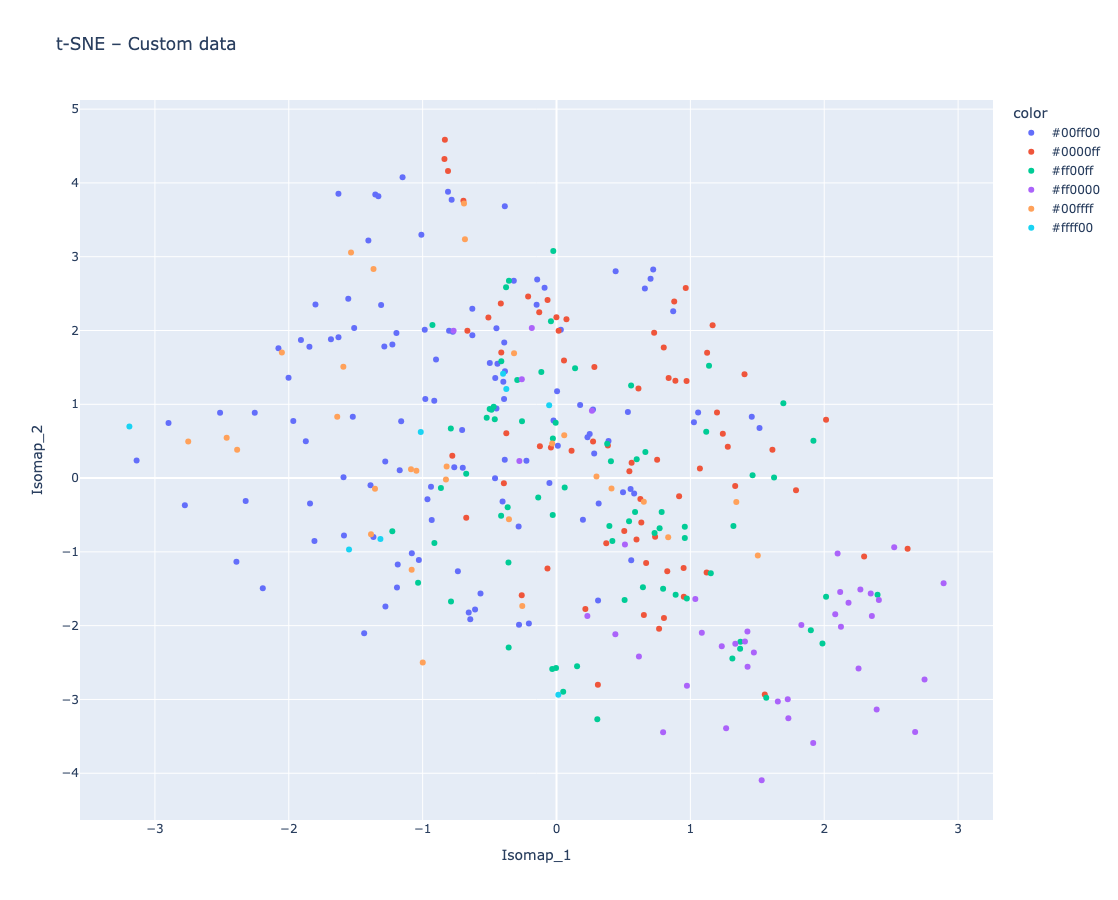

==== Raw data perf : ====
Dist correlation : 0.7160073519135892
Trustworthiness : 0.9745222387742073
Continuity : 0.9915149795464756
MRRE : 0.4097081603725965
==== Per90 data perf : ====
Dist correlation : 0.7467583511848792
Trustworthiness : 0.9711484713059516
Continuity : 0.9914128301529876
MRRE : 0.4404158831095289
==== Custom data perf : ====
Dist correlation : 0.7509202550844533
Trustworthiness : 0.9668742758506538
Continuity : 0.9908576292828262
MRRE : 0.45144430508040256


In [60]:
position_colors = {
    'FW': np.array([255, 0, 0]),    # red
    'MF': np.array([0, 0, 255]),    # blue
    'DF': np.array([0, 255, 0]),  #  yellow
}

def color_from_position(positions):
    postitions = str(positions)
    position_list = positions.split(',')
    colors = np.array([position_colors[p] for p in position_list if p in position_colors])
    avg_color = np.sum(colors, axis=0)
    return '#%02x%02x%02x' % tuple(avg_color.astype(int))

def plot_isomap_interactive(X_tsne, player_positions, data_num, title):
    df_plot = pd.DataFrame({
        'Isomap_1': X_tsne[:, 0],
        'Isomap_2': X_tsne[:, 1],
        'player_name': data_num.index,
        'color' : player_positions.apply(color_from_position)
    })
    
    fig = px.scatter(
        df_plot,
        x='Isomap_1', y='Isomap_2',
        hover_name='player_name',
        color='color',
        title=title,
        height=900, width=1100 
    )
    fig.show()

plot_isomap_interactive(X_tsne_raw, player_positions_raw ,data_raw.set_index("player_name"), "t-SNE – Raw data")
plot_isomap_interactive(X_tsne_per90, player_positions_per90 ,data_per90.set_index("player_name"), "t-SNE – Per90min data")
plot_isomap_interactive(X_tsne_custom, player_positions_custom ,data_custom.set_index("player_name"), "t-SNE – Custom data")

corr_raw, trust_raw, cont_raw, mrre_raw = extractMetrics_tsne(X_raw, X_tsne_raw)
corr_per90, trust_per90, cont_per90, mrre_per90 = extractMetrics_tsne(X_per90, X_tsne_per90)
corr_custom, trust_custom, cont_custom, mrre_custom = extractMetrics_tsne(X_custom, X_tsne_custom)


print("==== Raw data perf : ====")
print(f"Dist correlation : {corr_raw}")
print(f"Trustworthiness : {trust_raw}")
print(f"Continuity : {cont_raw}")
print(f"MRRE : {mrre_raw}")

print("==== Per90 data perf : ====")
print(f"Dist correlation : {corr_per90}")
print(f"Trustworthiness : {trust_per90}")
print(f"Continuity : {cont_per90}")
print(f"MRRE : {mrre_per90}")

print("==== Custom data perf : ====")
print(f"Dist correlation : {corr_custom}")
print(f"Trustworthiness : {trust_custom}")
print(f"Continuity : {cont_custom}")
print(f"MRRE : {mrre_custom}")    

## t-SNE dim Reduction Export

In [61]:
def export_tsne(X_tsne, data, prefix):
    player_names = data['player_name']
    teams = data['equipe']
    positions = data['positions']

    tsne_df = pd.DataFrame(X_tsne, columns=[f'tsne_{i+1}' for i in range(X_tsne.shape[1])])
    
    tsne_df['player_name'] = player_names
    tsne_df['equipe'] = teams
    tsne_df['positions'] = positions
    
    filename = f"../../reduced_data/joueurs_ligue1_tSNE_{prefix}.csv"
    tsne_df.to_csv(filename, index=False, encoding="utf-8")
    print(f"✅ Exported {filename} ({tsne_df.shape[0]} rows, {tsne_df.shape[1]} columns)")

export_tsne(X_tsne_raw, data_raw, prefix='raw')
export_tsne(X_tsne_per90, data_per90, prefix='per90')
export_tsne(X_tsne_custom, data_custom, prefix='custom')

✅ Exported ../../reduced_data/joueurs_ligue1_tSNE_raw.csv (333 rows, 7 columns)
✅ Exported ../../reduced_data/joueurs_ligue1_tSNE_per90.csv (333 rows, 7 columns)
✅ Exported ../../reduced_data/joueurs_ligue1_tSNE_custom.csv (333 rows, 7 columns)
